<a href="https://colab.research.google.com/github/Koks-creator/TensorflowSpeechToCommand/blob/main/SpeechToCommand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [2]:
import os
import pathlib
from typing import Tuple

import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.data.ops.map_op import _ParallelMapDataset
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
!pip freeze | grep tensorflow

tensorflow==2.14.0
tensorflow-datasets==4.9.6
tensorflow-estimator==2.14.0
tensorflow-hub==0.16.1
tensorflow-io-gcs-filesystem==0.37.1
tensorflow-metadata==1.16.1
tensorflow-probability==0.24.0


**NOTE**

**Explanation and Comparison of the Waveform and Spectrogram:**

##1. Waveform:

- A waveform is a graphical representation of an audio signal in the time domain. It shows how the amplitude (sound level) changes over time.

- On the x-axis, we have time (or signal samples), and on the y-axis, we have the amplitude values.

- You can clearly see that the amplitude increases around the middle of the graph and then decreases. This indicates that the sound starts softly, gets louder, and then quiets down again.

- A waveform is easy to interpret in terms of volume and the overall shape of the signal, but it does't provide information about the frequency content of the sound (e.g., whether low or high tones are present).


##2. Spectrogram:

- A spectrogram is a representation of the audio signal in the frequency domain. It shows how the energy of the signal is distributed across different frequencies over time.

- The x-axis represents time, just like in the waveform.

- The y-axis represents frequencies (from low to high).

- The colors indicate the intensity (energy) of the sound at a given frequency
from green (lower energy) to yellow (higher energy). You can clearly see bright yellow bands at certain points, which means that the signal contains more energy at specific frequencies during those moments.

In [4]:
ORIGIN = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"
ZIP_FILE = "mini_speech_commands.zip"
DATASET_PATH = "data/mini_speech_commands"
EPOCHS = 15
LR = 0.001
TRAIN_SIZE = .8
VAL_SIZE = .1
TEST_SIZE = .1
AUTOTUNE = tf.data.AUTOTUNE # special constant that automatically adjusts the number of concurrent threads or processes to process data in the data pipeline
INPUT_LEN = 16000
BATCH_SIZE = 8
MODEL_NAME = "AudioModel7.h5"

#Download data

In [5]:
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      ZIP_FILE,
      origin=ORIGIN,
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


#Preprocess

In [6]:
commands = np.array(tf.io.gfile.listdir(data_dir))
commands = commands[commands != 'README.md']
print(f"{commands=}")

commands=array(['down', 'right', 'no', 'go', 'stop', 'yes', 'left', 'up'],
      dtype='<U9')


In [7]:
filenames = tf.io.gfile.glob(f"{data_dir}/*/*")  # na zwykly glob?
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(data_dir/commands[0])))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/left/b8b8cb52_nohash_2.wav', shape=(), dtype=string)


In [8]:
train_range = slice(0, int(TRAIN_SIZE * num_samples))
val_range = slice(int(train_range.stop), int(train_range.stop + (VAL_SIZE * num_samples)))
test_range = slice(val_range.stop, int(val_range.stop + (VAL_SIZE * num_samples)))

print(f"{train_range=}")
print(f"{val_range=}")
print(f"{test_range=}")

train_range=slice(0, 6400, None)
val_range=slice(6400, 7200, None)
test_range=slice(7200, 8000, None)


In [9]:
train_files = filenames[train_range]
val_files = filenames[val_range]
test_files = filenames[test_range]

In [10]:
def decode_audio(audio_binary: EagerTensor) -> EagerTensor:
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    print(audio.shape)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)


def get_label(file_path: str) -> EagerTensor:
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep)
    print(parts)
    return parts[-2]


def get_waveform_and_label(file_path: str) -> Tuple[EagerTensor, EagerTensor]:
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)

    return waveform, label


def plot_waveform(rows: int, cols: int, dataset: EagerTensor) -> None:
    n = rows * cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

    for i, (audio, label) in enumerate(dataset.take(n)):
        r = i // cols
        c = i % cols
        ax = axes[r][c]
        ax.plot(audio.numpy())
        ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
        label = label.numpy().decode('utf-8')
        ax.set_title(label)

    plt.show()


def get_spectrogram(waveform: EagerTensor) -> EagerTensor:
    # Zero-padding for an audio waveform with less than 16,000 samples.
    waveform = waveform[:INPUT_LEN]
    zero_padding = tf.zeros(
        [INPUT_LEN] - tf.shape(waveform),
        dtype=tf.float32
        )

    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)

    # Convert the waveform to a spectrogram
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so we can have image like stuff, so we can use fucking cnn shit here
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def plot_spectrogram(spectrogram: EagerTensor, ax: Axes) -> None:
    if spectrogram.ndim == 3:
        spectrogram = np.squeeze(spectrogram)
    print(spectrogram.shape)
    # Convert frequencies to a logarithmic scale so that time is on the x-axis
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)

    ax.pcolormesh(np.arange(log_spec.shape[1]), np.arange(log_spec.shape[0]), log_spec)

def get_spectrogram_and_label_id(audio, label) -> Tuple[EagerTensor, int]:
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

def preprocess_dataset(files: EagerTensor) -> _ParallelMapDataset:
    files_ds = tf.data.Dataset.from_tensor_slices(files)

    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)

    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)

    return output_ds

In [11]:
files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

waveform_ds_copy = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
(None, None)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
(None, None)


In [12]:
for i, (audio, label) in enumerate(waveform_ds_copy.take(5)):
    print(label)

tf.Tensor(b'left', shape=(), dtype=string)
tf.Tensor(b'go', shape=(), dtype=string)
tf.Tensor(b'left', shape=(), dtype=string)
tf.Tensor(b'go', shape=(), dtype=string)
tf.Tensor(b'down', shape=(), dtype=string)


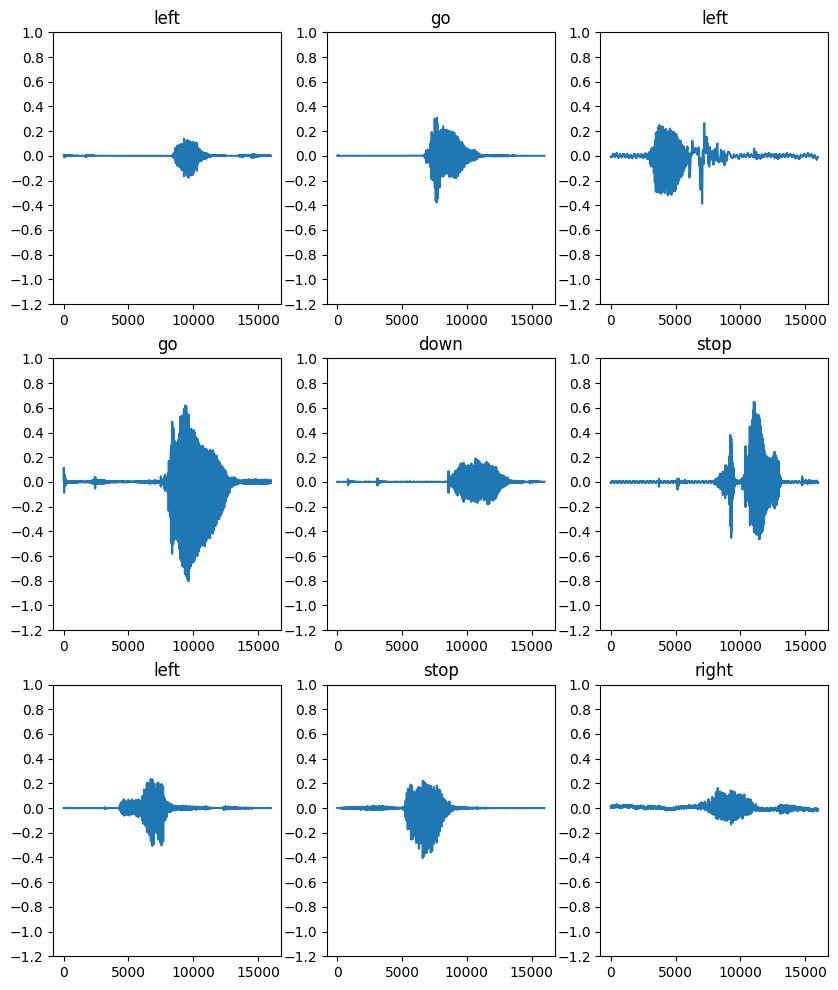

In [13]:
plot_waveform(rows=3, cols=3, dataset=waveform_ds)

In [14]:
for waveform, label in waveform_ds_copy.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=INPUT_LEN))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
audio_binary = tf.io.read_file("/content/data/mini_speech_commands/down/15c563d7_nohash_2.wav")
waveform = decode_audio(audio_binary)

display.display(display.Audio(waveform, rate=INPUT_LEN))

(16000, 1)


In [16]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

(124, 129)
(124, 129)
(124, 129)
(124, 129)
(124, 129)
(124, 129)
(124, 129)
(124, 129)
(124, 129)


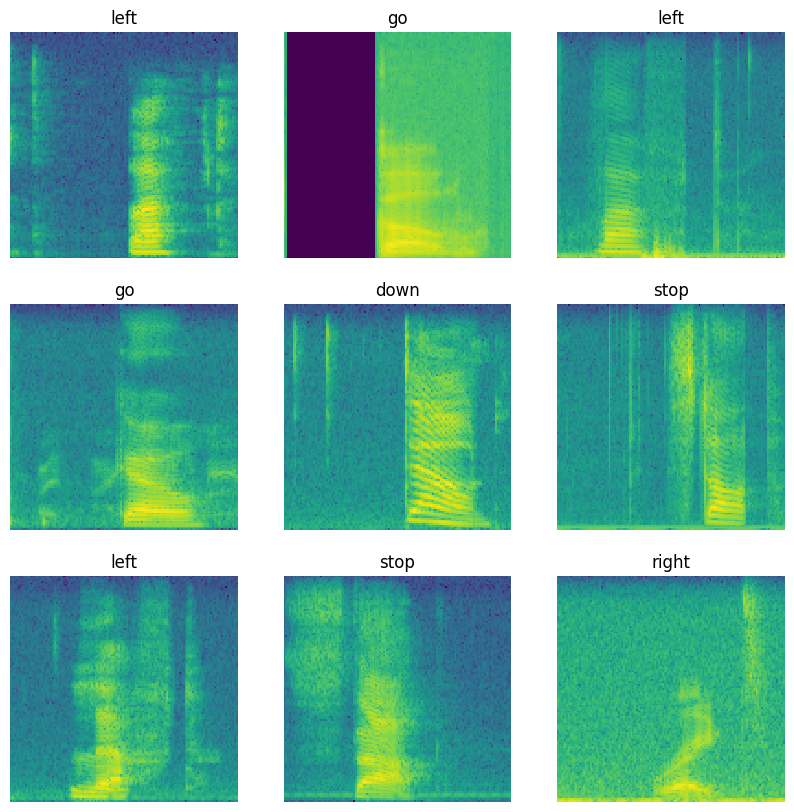

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

In [18]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
(None, None)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
(None, None)


In [19]:
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

In [20]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

#Model

In [21]:
for spectrogram, _ in spectrogram_ds.take(1):
   input_shape = spectrogram.shape
print(f"{input_shape=}")

num_labels = len(commands)
print(f"{commands=}")

input_shape=TensorShape([124, 129, 1])
commands=array(['down', 'right', 'no', 'go', 'stop', 'yes', 'left', 'up'],
      dtype='<U9')


In [22]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(64, 64), #32
    # Normalize.
    norm_layer,
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizati  (None, 64, 64, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0

#Training

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [24]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15
800/800 [==============================] - 76s 94ms/step - loss: 1.4268 - accuracy: 0.4658 - val_loss: 0.7682 - val_accuracy: 0.7175
Epoch 2/15
800/800 [==============================] - 66s 82ms/step - loss: 0.5916 - accuracy: 0.7894 - val_loss: 0.4248 - val_accuracy: 0.8600
Epoch 3/15
800/800 [==============================] - 61s 76ms/step - loss: 0.3765 - accuracy: 0.8728 - val_loss: 0.3388 - val_accuracy: 0.8950
Epoch 4/15
800/800 [==============================] - 63s 79ms/step - loss: 0.2930 - accuracy: 0.9023 - val_loss: 0.4023 - val_accuracy: 0.8813
Epoch 5/15
800/800 [==============================] - 63s 79ms/step - loss: 0.2539 - accuracy: 0.9181 - val_loss: 0.4648 - val_accuracy: 0.8763
Epoch 6/15
800/800 [==============================] - 61s 76ms/step - loss: 0.2296 - accuracy: 0.9220 - val_loss: 0.3734 - val_accuracy: 0.8988
Epoch 7/15
800/800 [==============================] - 64s 79ms/step - loss: 0.1898 - accuracy: 0.9367 - val_loss: 0.3465 - val_accuracy:

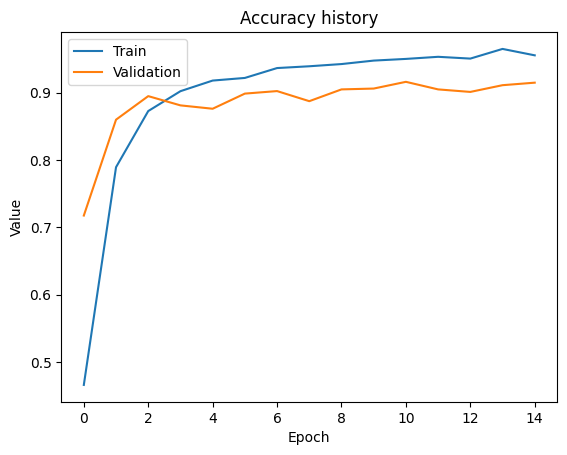

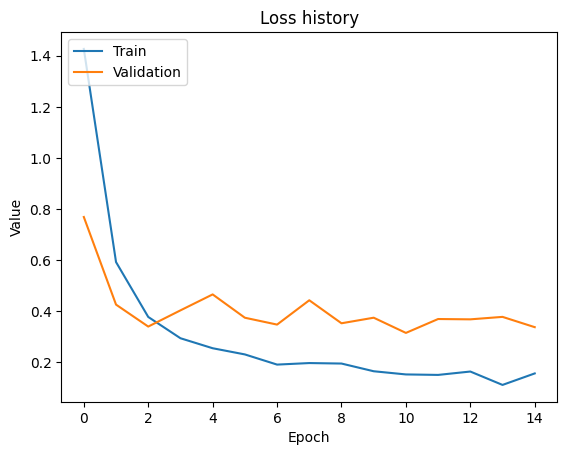

In [25]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy history")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss history")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Testing

In [26]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [27]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f"Test set accuracy: {test_acc:.0%}")

25/25 [==============================] - 2s 63ms/step
Test set accuracy: 92%


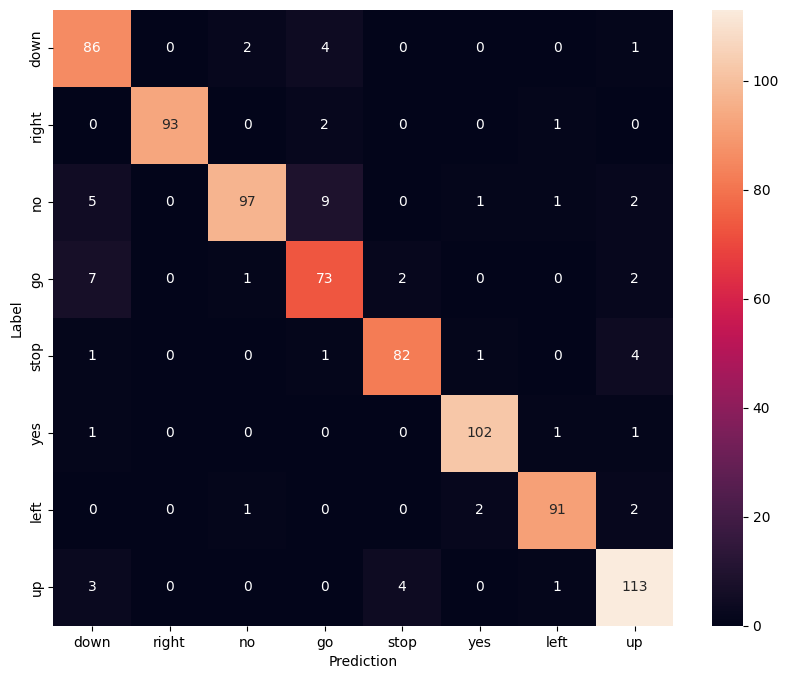

In [28]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()

Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
(None, None)
prediction=<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[1.0000000e+00, 1.9569840e-10, 1.0743072e-08, 1.1908378e-09,
        1.3083600e-14, 1.1258770e-12, 1.8541202e-12, 3.8601778e-12]],
      dtype=float32)>
prediction=<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.2797081 , 0.10289886, 0.10289886, 0.10289886, 0.10289886,
       0.10289886, 0.10289886, 0.10289886], dtype=float32)>


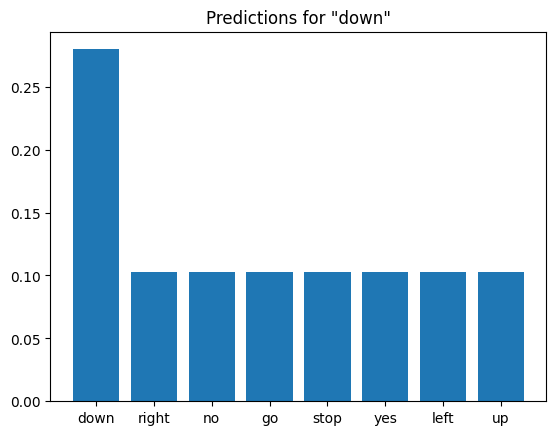

In [29]:
sample_file = data_dir/'down/004ae714_nohash_0.wav'
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    print(f"{prediction=}")

    prediction = tf.nn.softmax(prediction[0])
    print(f"{prediction=}")

    plt.bar(commands, prediction)
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

# Save model

In [30]:
with open("classes.txt", "w") as cf:
    cf.write("\n".join(list(commands)))
list(commands)

['down', 'right', 'no', 'go', 'stop', 'yes', 'left', 'up']

In [31]:
model.save(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Load model

In [32]:
model2 = tf.keras.models.load_model(MODEL_NAME)

Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
(None, None)
prediction=<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[1.0000000e+00, 9.2514990e-21, 7.8006779e-15, 2.4942826e-12,
        2.1544893e-18, 4.0204926e-20, 4.2628589e-22, 1.3821822e-19]],
      dtype=float32)>
prediction=<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.2797081 , 0.10289886, 0.10289886, 0.10289886, 0.10289886,
       0.10289886, 0.10289886, 0.10289886], dtype=float32)>


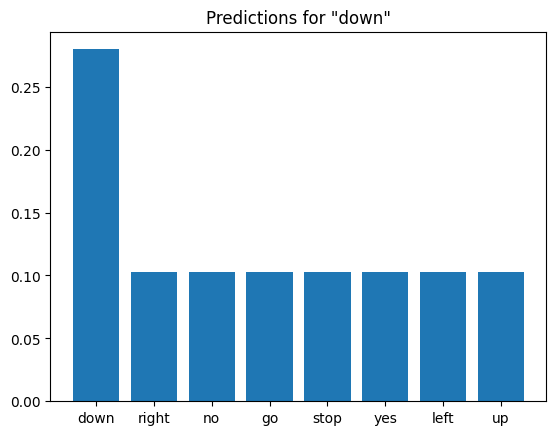

In [33]:
sample_file = "/content/data/mini_speech_commands/down/00b01445_nohash_1.wav"
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    print(f"{prediction=}")

    prediction = tf.nn.softmax(prediction[0])
    print(f"{prediction=}")

    plt.bar(commands, prediction)
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()